## Homework 2: Food deserts

In this assignment, we'll use a variety of data sources to quantify the existence of food deserts in LA County. The assignment is *loosely* based on the food pantry example from class. It focuses on honing your skills in processing and joining data together, particularly spatially.

A quick note: It's great to look at your variables, dataframes, etc. while you are exploring the data. But **please comment out those exploratory lines of code before submitting**. It makes it hard for us to find your solutions.

Your repository includes a csv file of SNAP-authorized retailers. [It was downloaded from USDA.](https://www.fns.usda.gov/snap/retailer-locator) To my knowledge, this is the most comprehensive list of grocery outlets in the US.

Load it into a pandas dataframe called `snapDf`. Keep only the observations that are in Los Angeles County. 

In [68]:
# your code here
snapDf = 999  # replace with your DataFrame
    
### BEGIN SOLUTION

import pandas as pd
snapDf = pd.read_csv('SNAP_Store_Locations.csv')
snapDf = snapDf[snapDf.County=='LOS ANGELES']
### END SOLUTION


In [69]:
# Autograding tests - do not edit
print(snapDf.columns)
print(snapDf.County.unique())
print(len(snapDf))
assert all(snapDf.columns == ['X', 'Y', 'ObjectId', 'Store_Name', 'Address', 'Address_Line__2',
       'City', 'State', 'Zip5', 'Zip4', 'County', 'Longitude', 'Latitude'])
assert all(snapDf.County=='LOS ANGELES')
assert len(snapDf)==6185

Index(['X', 'Y', 'ObjectId', 'Store_Name', 'Address', 'Address_Line__2',
       'City', 'State', 'Zip5', 'Zip4', 'County', 'Longitude', 'Latitude'],
      dtype='object')
['LOS ANGELES']
6185


If you look at the store names, many of the places that accept SNAP benefits are liquor stores and gas stations. These might have an important role where no other food is available, but are likely to have a limited range of food, particularly fresh produce. 

Let's keep them in the dataset for the moment, but create a new column, `liquor_or_gas`, that is `True` if the store has `liquor` or `gas` in its name (`Store_Name`), and is `False` otherwise. Note that `True` and `False` should be boolean values, not the strings `"True"` and `"False"`. 

Pay attention to upper vs lower case! But don't worry about spelling errors here (although in practice, that should be part of your data cleaning).

*Hint:* you can use `apply` with either a `lambda` anonymous function or a regular function. Look at the example from class where we create the `ped_accident_numeric` variable.

In [70]:
# your code here

### BEGIN SOLUTION

snapDf['liquor_or_gas'] = snapDf.Store_Name.apply(lambda x: 
                            True if 'liquor' in x.lower() or 'gas' in x.lower() else False)
### END SOLUTION

In [71]:
# Autograding tests - do not edit
print(snapDf.liquor_or_gas.mean().round(2))
print(snapDf.liquor_or_gas.dtype)
assert snapDf.liquor_or_gas.mean().round(2) == 0.13
assert snapDf.liquor_or_gas.dtype=='bool'

0.13
bool


Let's have a quick look at how the proportion of liquor stores / gas stations varies by city. If you look at the `City` field, there's some cleaning that needs to be done first, however.

Replace the `City` field so that all the cities are in Title case. (Title case means the first letter of each word is capitalized, such as Los Angeles or North Hollywood.)

*Hint:* The `title()` function works the same way as `upper()` and `lower()`.

In [72]:
# your code here


### BEGIN SOLUTION

snapDf.City = snapDf.City.str.title()

### END SOLUTION

In [73]:
# Autograding tests - do not edit
print(len(snapDf.City.unique()))
assert len(snapDf.City.unique()) == 148
assert 'Los Angeles' in snapDf.City.values

148


Now, look at the proportion of liquor stores / gas stations by city. 

In which cities are at least 25% of the SNAP outlets liquor stores or gas stations? Assign this list of cities and their means to a `pandas` `Series` called `cities_subset`. (Remember, a `Series` is like a one-column `DataFrame`.) 

*Hint:* You'll need to `groupby` the `City` field to get the means for all cities. Then, in a second line, restrict your result to just those cities with a mean of at least 25%.

In [74]:
# your code here
cities_subset = 999 # replace 999 with your answer

### BEGIN SOLUTION
cities_subset = snapDf.groupby('City').liquor_or_gas.mean()
cities_subset = cities_subset[cities_subset>0.24]
### END SOLUTION

In [75]:
# Autograding tests - do not edit
print(len(cities_subset))
assert isinstance(cities_subset, pd.Series)
assert len(cities_subset)==11

11


Now, let's bring in the [California EnviroScreen data](https://oehha.ca.gov/calenviroscreen/maps-data). This has both demographic and environmental justice-related data, and also the spatial boundaries of census tracts. We used it in class, so it will be in your GitHub course repository.

Load the data in to a `geopandas` `GeoDataFrame` called `esGdf`, and restrict it to the tracts in LA county.

In [76]:
# your code here
import geopandas as gpd
esGdf = 999 # replace with your code

### BEGIN SOLUTION
# grading note: the hw respository should be in the same directory as the course repository for this to work
esGdf = gpd.read_file('../../urbandatascience-s22/Lectures/data/CalEnviroScreen/CES4 Final Shapefile.shp')
esGdf = esGdf[esGdf.County=='Los Angeles']
### END SOLUTION

In [77]:
# Autograding tests - do not edit
print(len(esGdf))
assert len(esGdf)==2343
assert isinstance(esGdf, gpd.GeoDataFrame)

2343


First, let's do a tabular (non-spatial) join to ZIP code.

Create a new dataframe called `zipcodes` with one row for each ZIP code, that includes the following columns:
* `n_SNAP`: the number of SNAP outlets
* `n_SNAP_excl_liquor_gas`: the number of SNAP outlets excluding liquor and gas stores
* `es_percentile`: the mean EnviroScreen percentile (`CIscoreP`) for census tracts that intersect the ZIP code

(In practice, we might want to weight census tracts by area or population, but don't worry about that here.)

*Hints*:
- I recommend creating three temporary dataframes (or Series) at the ZIP-code level with the number of SNAP outlets, the number of non-liquor and gas store SNAP outlets, and the mean score
- If you get an error that `Series object has no attribute 'join'`, you can convert that Series to a DataFrame: `pd.DataFrame(your_series_name)` 
- Then, you can join them all together
- You'll probably need to rename the columns
- Remember to include all ZIP codes, including ones without a SNAP outlet, and replace NaNs with zeros if appropriate

In [78]:
# your code here
zipcodes = 999

### BEGIN SOLUTION
# create tmp dataframes
tmp1 = snapDf.groupby('Zip5').size()
tmp1.name = 'n_SNAP'
tmp2 = snapDf[snapDf.liquor_or_gas==False].groupby('Zip5').size()
tmp2.name = 'n_SNAP_excl_liquor_gas'
tmp3 = esGdf.groupby('ZIP').CIscoreP.mean()

# join them together. Note that the indexes should already be the ZIP code
# do a left join from the EnviroScreen data to keep all the ZIP codes
# we could also have done an outer join in any order
zipcodes = pd.DataFrame(tmp3).join(tmp1).join(tmp2)

# replace missing data
zipcodes.n_SNAP.fillna(0, inplace=True)
zipcodes.n_SNAP_excl_liquor_gas.fillna(0, inplace=True)

### END SOLUTION

In [79]:
# Autograding tests - do not edit

print(len(zipcodes))
print(zipcodes.mean())

assert len(zipcodes) == 282
assert zipcodes.CIscoreP.mean().round(2) == 26.70
assert zipcodes.n_SNAP_excl_liquor_gas.mean().round(2) == 18.97

282
CIscoreP                  26.698875
n_SNAP                    21.861702
n_SNAP_excl_liquor_gas    18.971631
dtype: float64


Now let's do a spatial join. 

`esGdf` already has a `geometry` column and is a GeoDataFrame, but `snapDf` is a regular pandas DataFrame.

Use the `Latitude` and `Longitude` columns to add a point geometry field to `snapDf`, and turn it into a `GeoDataFrame` called `snapGdf`. 

In [80]:
# your code here
snapGdf = 999 # replace 999 with your solution

### BEGIN SOLUTION
snapGdf = gpd.GeoDataFrame(
    snapDf, geometry=gpd.points_from_xy(snapDf.Longitude, snapDf.Latitude, crs='EPSG:4326'))

### END SOLUTION


In [81]:
# Autograding tests - do not edit
print(snapGdf.geometry.x.min())
print(snapGdf.geometry.y.max())
assert isinstance(snapGdf, gpd.GeoDataFrame)
assert snapGdf.geometry.x.min().round(2) == -118.81
assert snapGdf.geometry.y.max().round(2) == 35.13

-118.80946
35.127529


Now, let's join the two GeoDataFrames together. The aim: count the number of SNAP outlets (in both our liquor store/gas station and other categories) per census tract.

There are several ways to do it. My suggestion is as follows:
1. Add the `tract` column to `snapGdf` using a spatial join
2. Aggregate `snapGdf` by the new `tract` column using `groupby()`, to get a count of SNAP outlets in each tract
3. Join those counts to `esGdf`

Let's do these one step at a time. First, add the `tract` column to `snapGdf`. I suggest you use the `gpd.sjoin()` function and a left join. Call the new `GeoDataFrame` `snapGdf2`.

*Hint:* You might need to reproject!

In [82]:
# your code here
snapGdf2 = 999 # replace 999 with your code

### BEGIN SOLUTION
snapGdf2 = gpd.sjoin(snapGdf, esGdf.to_crs('EPSG:4326'), how="left", predicate='intersects')
### END SOLUTION

In [83]:
# Autograding tests - do not edit
print(len(snapGdf2))

assert len(snapGdf2)==6212
assert 'Tract' in snapGdf2.columns


6212


That should have been a 1:many join, not the 1:1 join that you might have been expecting. (You ended up with more rows than you started with). Think about what might have caused this! 

We didn't cover in class how to drop the duplicates, but the block of code below should fix it.

In [84]:
print('{} rows in snapGdf'.format(len(snapGdf)))
print('{} rows in snapGdf2 (after join)'.format(len(snapGdf2)))

# you can also see that the ObjectId column (which identifies the SNAP providers) 
# is unique before the join, but not after
print(snapGdf.ObjectId.is_unique)  # is there one row per SNAP outlet before the join?
print(snapGdf2.ObjectId.is_unique) # is there one row per SNAP outlet after the join?

# drop the duplicates by just taking the first ObjectId that joins to each tract
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
snapGdf2.drop_duplicates(subset='ObjectId', keep='first', inplace=True)
print('{} rows in snapGdf2 (after dropping duplicates)'.format(len(snapGdf2)))

6185 rows in snapGdf
6212 rows in snapGdf2 (after join)
True
False
6185 rows in snapGdf2 (after dropping duplicates)


Now, aggregate snapGdf2 by the new `tract` column to get a count of SNAP outlets in each census tract. Call the resulting Series `snap_counts`.

In [85]:
snap_counts = 999 # your code here

### BEGIN SOLUTION
snap_counts = snapGdf2.groupby('Tract').size()
snap_counts.name = 'n_snap'
### END SOLUTION


In [86]:
# Autograding tests - do not edit
print(snap_counts.sum())
assert snap_counts.sum() == 6144

6144


Final step in the join process! Let's join `snap_counts` back to `esGdf` to create a new geodataframe called `joinedGdf`. 

Call the new column `n_snap`. (*Hint*: the easiest way to get this name is to rename the Series in the previous answer.)

This should be a left join (so you don't leave out any census tracts) on the `Tract` column.

Remember to fill in any missing data with zeros, if appropriate.

In [87]:
joinedGdf = 999 # your answer here

### BEGIN SOLUTION
joinedGdf = esGdf.set_index('Tract').join(snap_counts, how='left')
joinedGdf.n_snap.fillna(0, inplace=True)
### END SOLUTION

In [88]:
# Autograding tests - do not edit

print(len(joinedGdf))
print(snap_counts.sum(), joinedGdf.n_snap.sum(), joinedGdf.n_snap.count())
assert len(joinedGdf) == len(esGdf)
assert snap_counts.sum() == joinedGdf.n_snap.sum()
assert joinedGdf.n_snap.count() == len(joinedGdf)

2343
6144 6144.0 2343


Now plot a map of the `n_outlets_other` column. Use the examples from class. At a minimum, your map should have:
* a basemap (e.g. from contextily)
* a legend or colorbar
* a title

If you can figure it out, you might want to drop Catalina Island to focus on mainland LA County. (Hint: the `ax.set_ylim()` function is useful here.)

Text(812.7651007123869, 0.5, 'number of outlets')

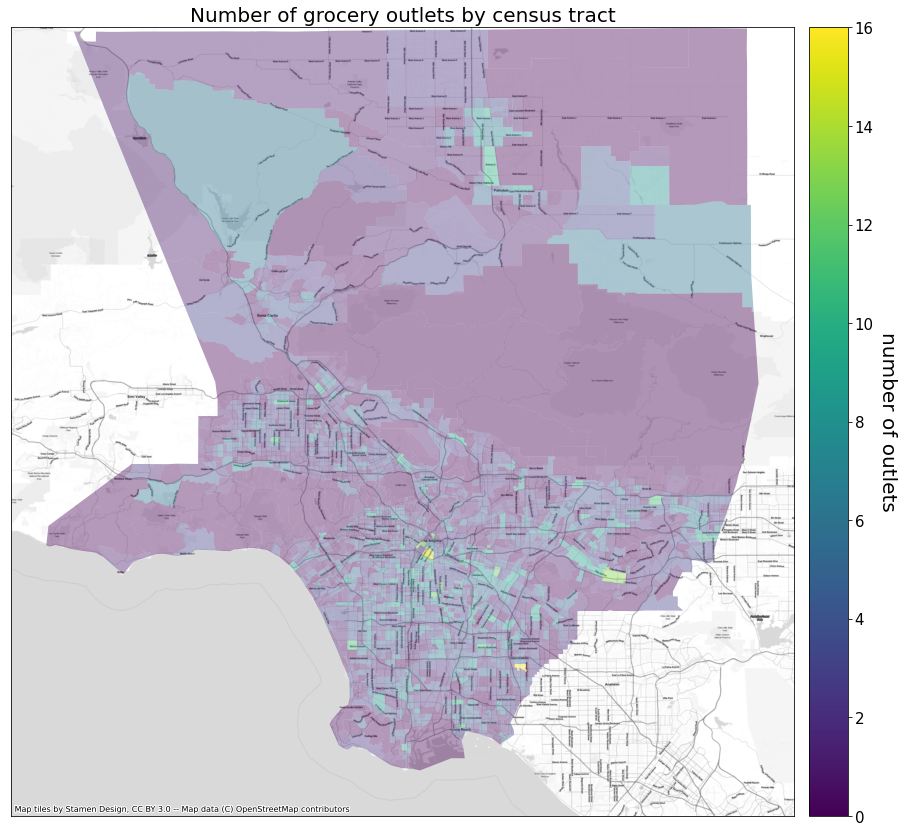

In [89]:
# your code here
import contextily as ctx
import matplotlib.pyplot as plt

### BEGIN SOLUTION
fig, ax = plt.subplots(figsize=(15,15))

# make color bar smaller
# following code from
# https://stackoverflow.com/questions/57541252/change-the-size-of-the-colorbar-in-geopandas-plot-i-got-error-unknown-property
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2) # depends on

joinedGdf.to_crs('EPSG:3857').plot('n_snap', cmap='viridis', legend=True, ax = ax, cax=cax, alpha=0.4)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)

# drop Catalina
ax.set_ylim([3.98e6, 4.14e6])

# and we really don't need the axis ticks and labels, so we set them to an empty list
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Number of grocery outlets by census tract', fontsize=20)

# adjust colorbar font size
# https://gis.stackexchange.com/questions/378416/how-to-change-the-font-size-of-the-color-bar-of-a-geopandas-choropleth-plot
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('number of outlets', fontsize=20, rotation=270, va='bottom' )
### END SOLUTION



Reflect on this assignment. What did you find most challenging? What problems did you encounter? How might you have gone about it differently the next time? (Write a few bullet points in a markdown cell.)

To help me calibrate future assignments, please also indicate about how long it took you to complete.

# Challenge Problem
Remember, you need to do at least two of these challenge problems this quarter.

We mapped the number of grocery stores, but didn't say anything directly about food deserts. In the challenge, take this analysis further. My suggestion:
* Normalize your number of outlets (e.g. by population) and plot these data
* Plot the normalized number of outlets (both gas/liquor and other) against race, income, and other variables from EnviroScreen
* Think about boundary issues created by the artefacts of census geography. Create a measure of the number of outlets within (say) 2km of a census tract boundary, even if they do not intersect that tract
* Briefly write a few sentences that intepret your results

If you want to go further, please do!







